# Task 10 - ML Facial Recognition to detect mood and Suggest Songs Accordingly

***Dataset :*** https://www.kaggle.com/datasets/msambare/fer2013

***Problem Statement :***

<img src="Screenshot 2023-03-30 115635.png" width="500">

### Import all the libraries

In [1]:
#Import Libraries/Packages

import numpy as np
import pandas as pd

import cv2
import os
import random
from skimage.io import imread

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import Audio

import warnings
warnings.filterwarnings('ignore')

### Data Visualization

In [2]:
train_dir = "data/train/"
test_dir = "data/test/"

total_labels = len(os.listdir(train_dir))
total_labels

7

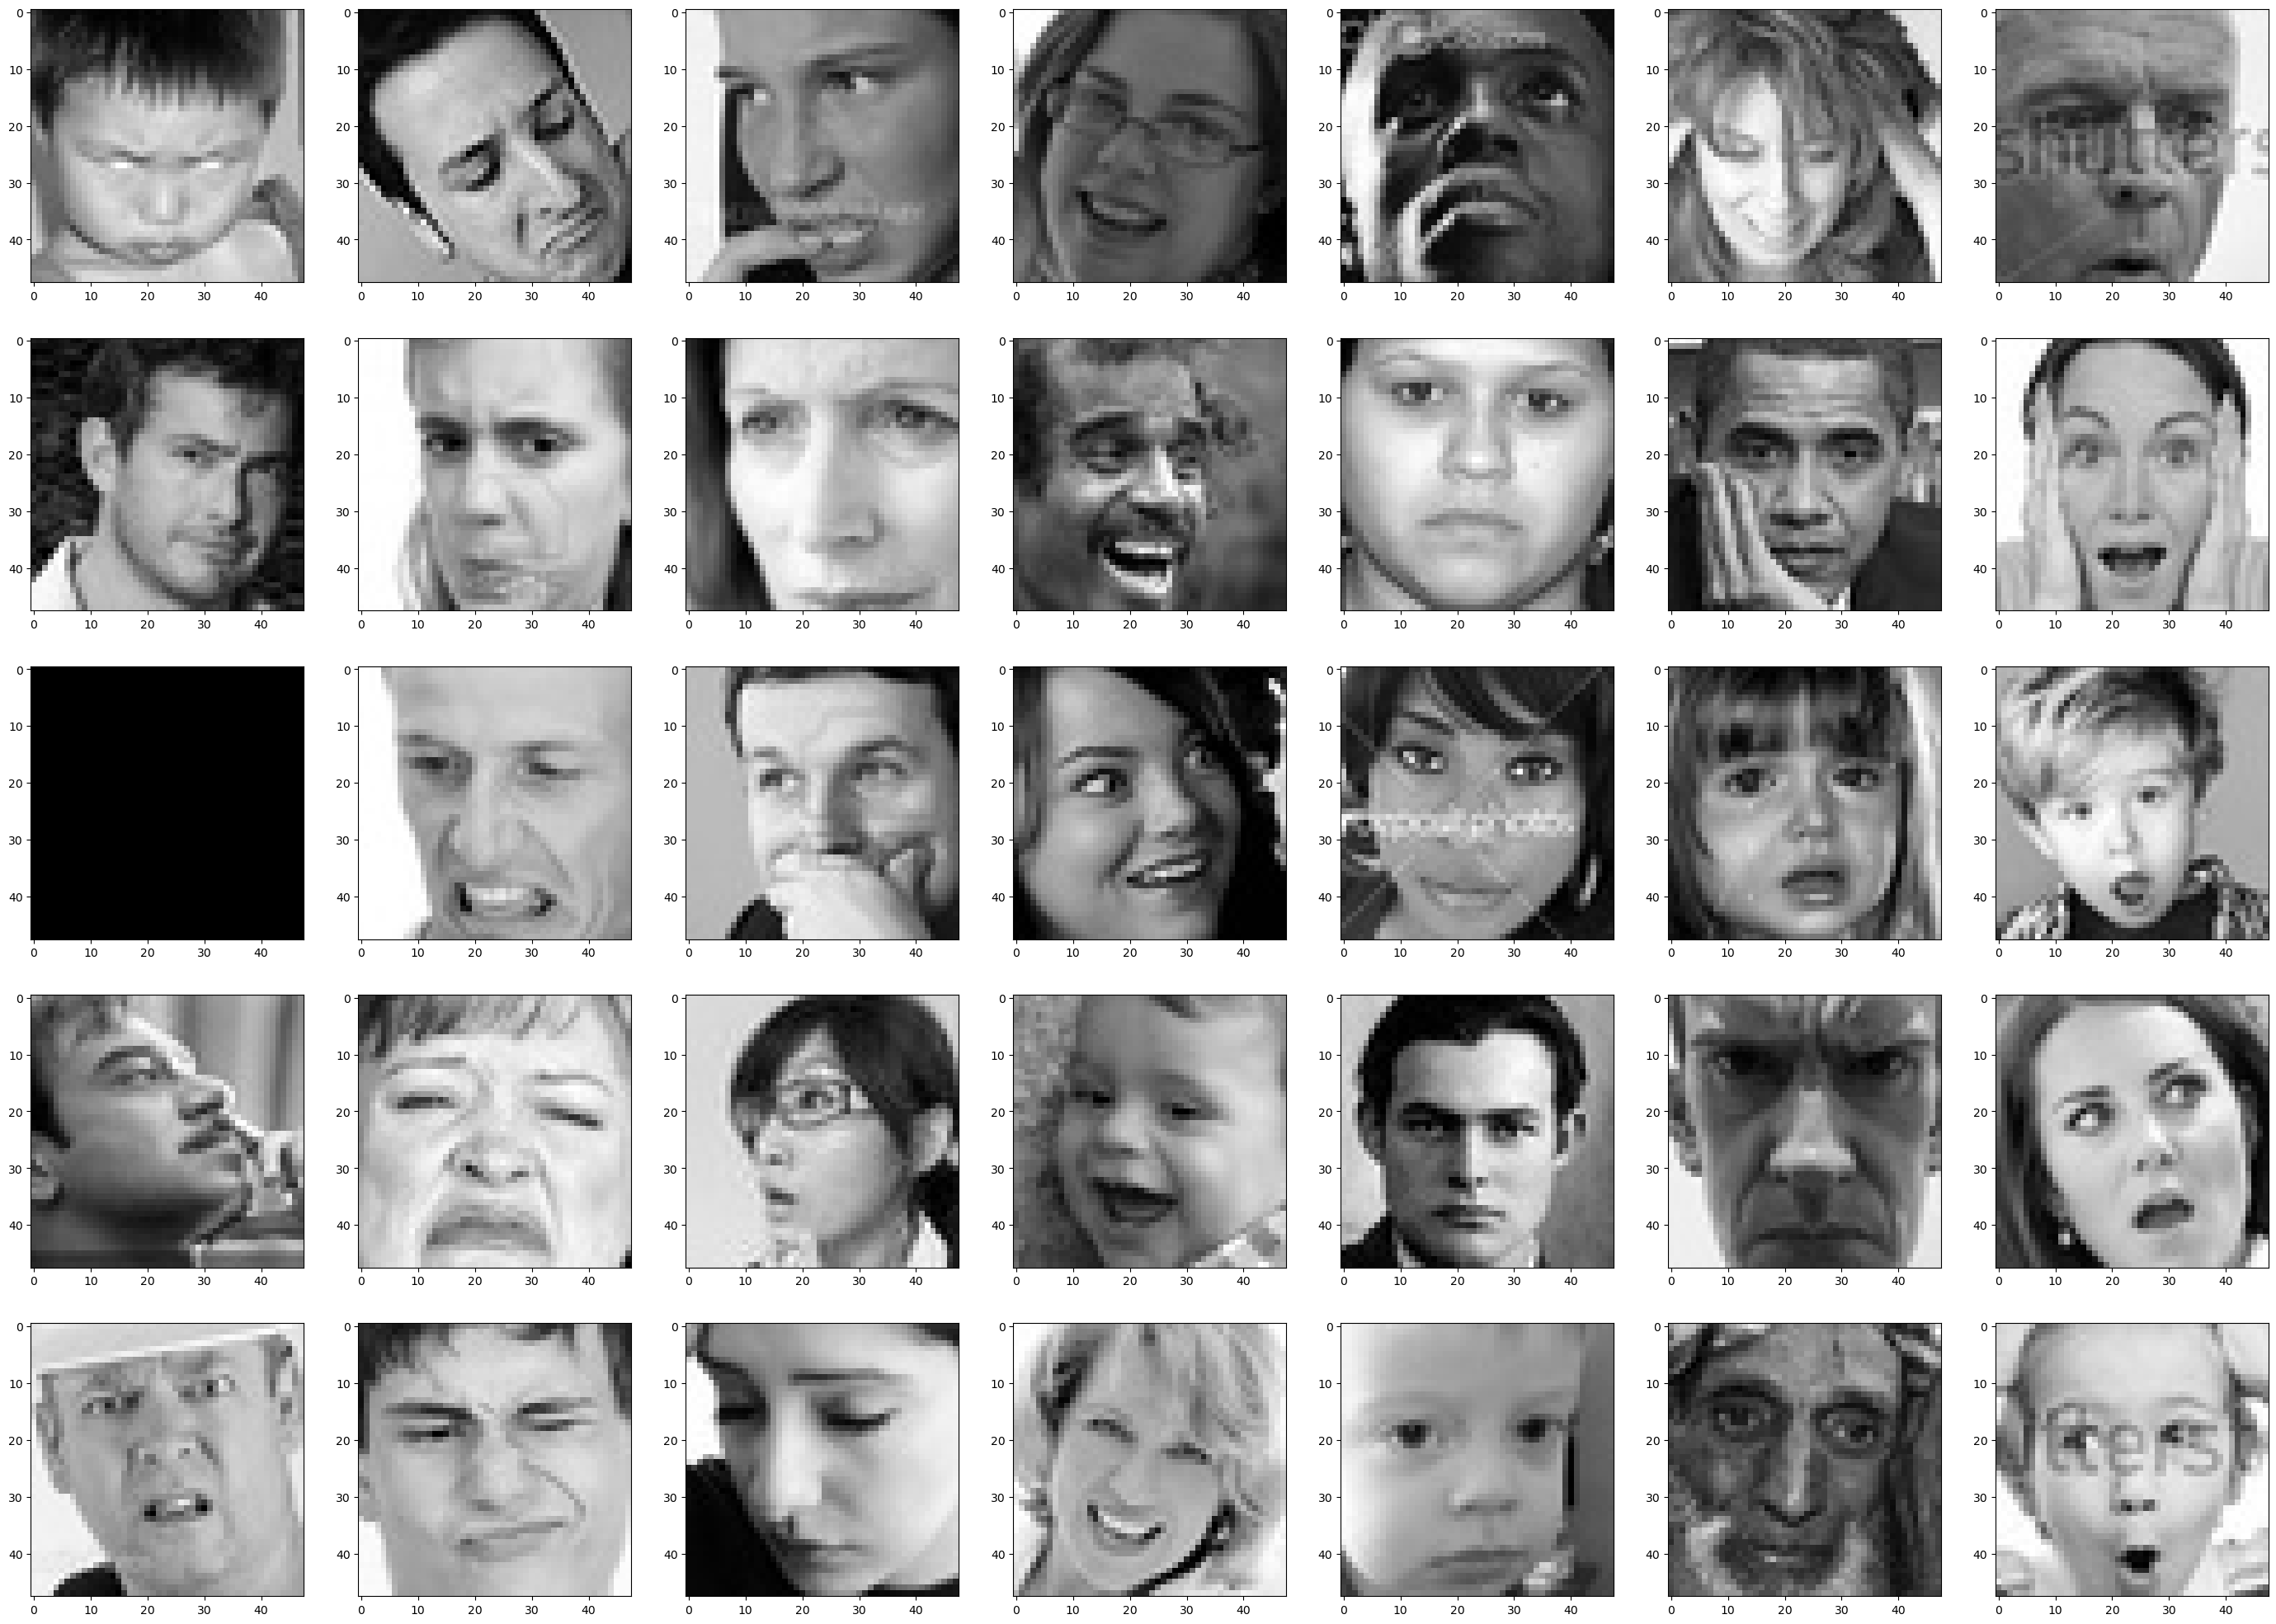

In [3]:
fig, ax = plt.subplots(nrows = 5, ncols = total_labels, figsize = (35, 25))

for x in range(5):
    for y, v in zip(range(total_labels), os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir + v + '/' + os.listdir(train_dir + v)[x]), cmap = 'gray')

plt.show()

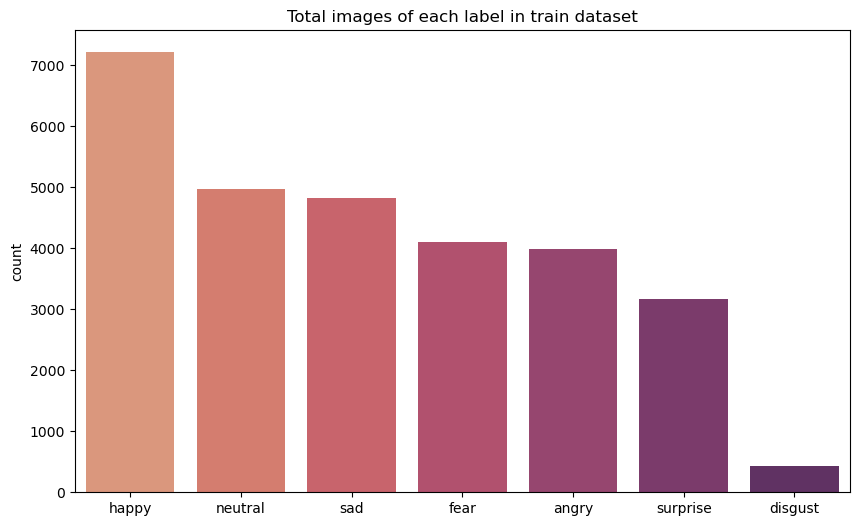

In [4]:
df = {}

for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))

df = pd.DataFrame(df, index = ["total"]).transpose().sort_values("total", ascending = False)

plt.figure(figsize = (10,6))
sns.barplot(x = df.index, y = "total", palette = "flare", data = df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

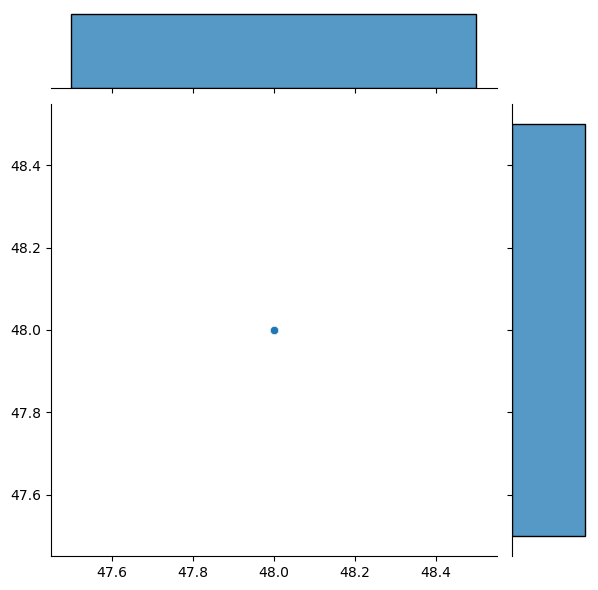

In [5]:
happy = os.listdir(train_dir + 'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir + 'happy/' + img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(x = dim1, y = dim2)
plt.show()

### Data Preprocessing

In [6]:
train_gen = ImageDataGenerator(rescale = 1 / 255,
                                rotation_range = 40,
                                width_shift_range = 0.2,
                                height_shift_range = 0.2,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                fill_mode = 'nearest')

test_gen = ImageDataGenerator(rescale = 1 / 255)

In [7]:
img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory = train_dir,
                                                target_size = (img_shape[0], img_shape[1]),
                                                color_mode = 'grayscale',
                                                batch_size = 64,
                                                class_mode = 'categorical',
                                                shuffle = True)

test_generator = test_gen.flow_from_directory(directory = test_dir,
                                                target_size = (img_shape[0], img_shape[1]),
                                                color_mode = 'grayscale',
                                                batch_size = 64,
                                                class_mode = 'categorical',
                                                shuffle = False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Creating Model

In [8]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = len(os.listdir(train_dir)), activation = 'softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

### Train the Model

In [10]:
# Train the model

model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001, 
                             decay = 1e-6), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [11]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size

history = model.fit(train_generator,
                    epochs = 20,
                    verbose = 1,
                    validation_data = test_generator,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps)

Epoch 1/20
448/448 [==============================] - 589s 1s/step - loss: 1.8761 - accuracy: 0.2306 - val_loss: 2.7786 - val_accuracy: 0.1886
Epoch 2/20
448/448 [==============================] - 632s 1s/step - loss: 1.7950 - accuracy: 0.2500 - val_loss: 1.7981 - val_accuracy: 0.2575
Epoch 3/20
448/448 [==============================] - 432s 964ms/step - loss: 1.7892 - accuracy: 0.2568 - val_loss: 1.7463 - val_accuracy: 0.2849
Epoch 4/20
448/448 [==============================] - 424s 946ms/step - loss: 1.7731 - accuracy: 0.2663 - val_loss: 1.7253 - val_accuracy: 0.3101
Epoch 5/20
448/448 [==============================] - 407s 907ms/step - loss: 1.7583 - accuracy: 0.2772 - val_loss: 1.7108 - val_accuracy: 0.3199
Epoch 6/20
448/448 [==============================] - 406s 907ms/step - loss: 1.7328 - accuracy: 0.2909 - val_loss: 1.6586 - val_accuracy: 0.3524
Epoch 7/20
448/448 [==============================] - 410s 916ms/step - loss: 1.7092 - accuracy: 0.3046 - val_loss: 1.6248 - val_a

### Save the Model

In [19]:
model.save("model.h5")

### Evaluation of the model

In [20]:
test_loss, test_acc = model.evaluate(test_generator)

print("validation accuracy :", str(test_acc * 100) + "%")
print("validation loss :", test_loss)

113/113 [==============================] - 32s 282ms/step - loss: 1.1939 - accuracy: 0.5432
validation accuracy : 54.31874990463257%
validation loss : 1.1939185857772827


### Plotting Training and Validation plot

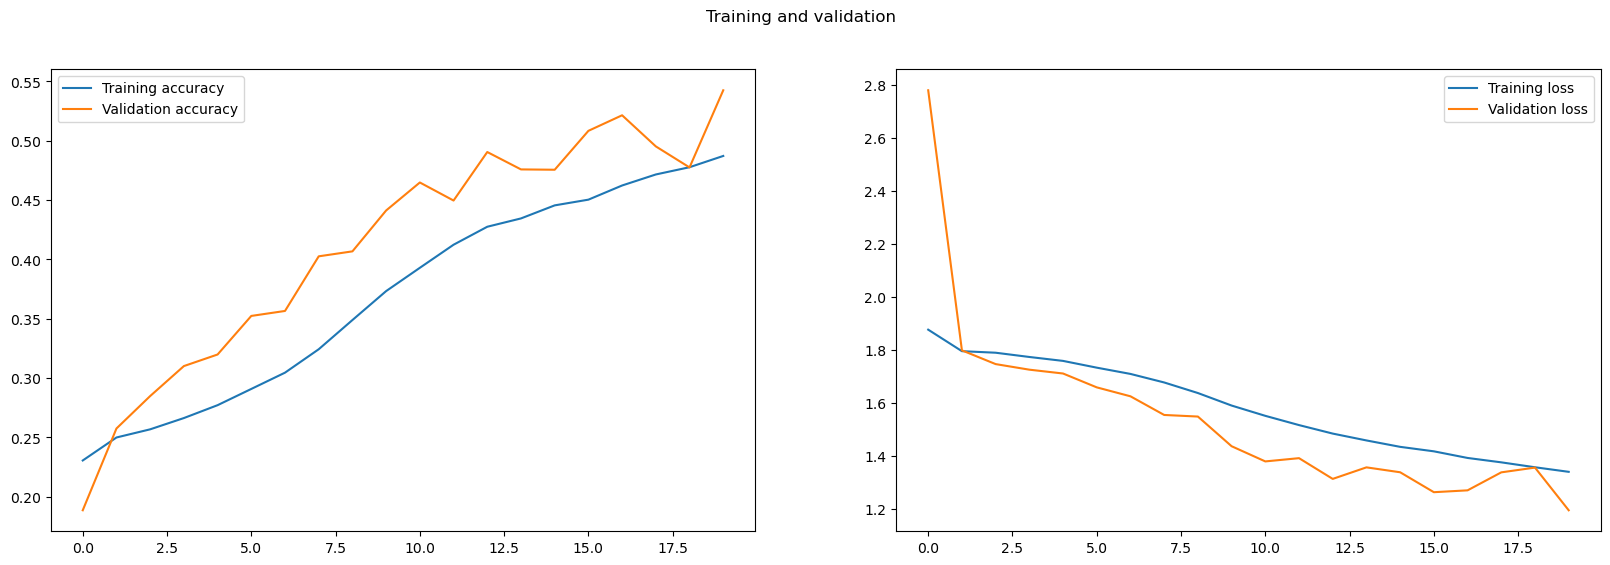

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
ax[0].plot(epochs, acc, label = 'Training accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation accuracy')
ax[0].legend(loc = 0)
ax[1].plot(epochs, loss, label='Training loss')
ax[1].plot(epochs, val_loss, label='Validation loss')
ax[1].legend(loc = 0)

plt.suptitle('Training and validation')
plt.show()

### Plotting the confusion matrix

113/113 [==============================] - 32s 284ms/step
              precision    recall  f1-score   support

       angry       0.44      0.47      0.45       958
     disgust       0.00      0.00      0.00       111
        fear       0.41      0.15      0.22      1024
       happy       0.71      0.85      0.77      1774
     neutral       0.44      0.66      0.53      1233
         sad       0.47      0.27      0.34      1247
    surprise       0.59      0.77      0.67       831

    accuracy                           0.54      7178
   macro avg       0.44      0.45      0.43      7178
weighted avg       0.52      0.54      0.51      7178





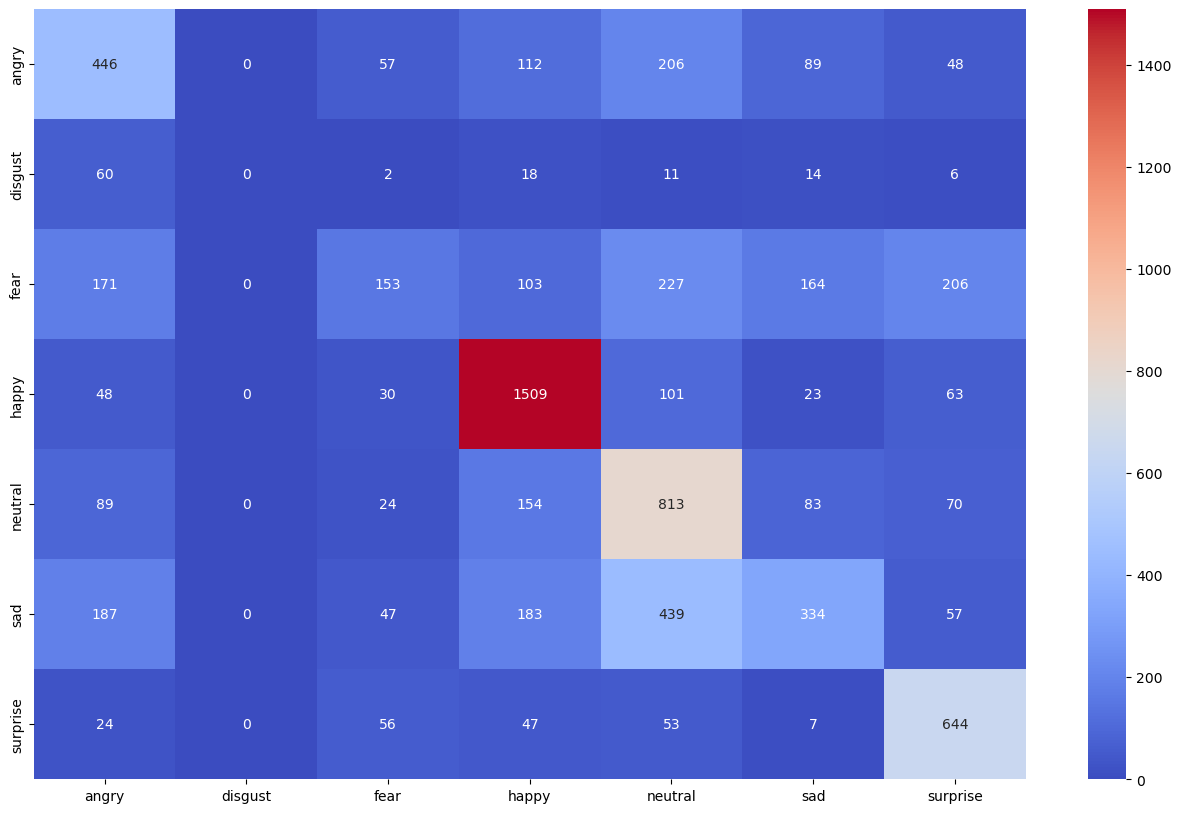

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis = -1)
print(classification_report(test_generator.classes, y_pred, target_names = test_generator.class_indices.keys()), end = '\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize = (16,10))
sns.heatmap(cm, cmap = plt.cm.coolwarm, annot = True, fmt = '.0f', xticklabels = test_generator.class_indices.keys(), yticklabels = test_generator.class_indices.keys())
plt.show()

### Testing our model with new image

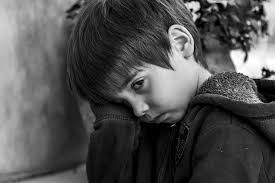

In [26]:
image = cv2.imread("images/sad.jpg")

from IPython.display import Image
Image(filename = 'images/sad.jpg')

### Model Prediction

In [27]:
# load the trained model
model = load_model("model.h5")

# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation = cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j) + "prediction rate is   {0:.2f}%".format(predictss))
    
print( "\n\n The system considers this expression to be:",label)

1/1 [==============================] - 0s 199ms/step
  Angry   prediction rate is   0.31%
 Disgust  prediction rate is   0.00%
  Happy   prediction rate is   0.10%
   Sad    prediction rate is   0.19%
 Surprise prediction rate is   0.11%
 Neutral  prediction rate is   0.20%


 The system considers this expression to be: Angry


### Song Recommdation

In [28]:
if (label == 'Angry'):
    path = "song\\Angry\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = 'song\\Angry\\' + d, autoplay = True)
    display(audio)
    
elif (label == 'Disgust'):
    path = "song\\Disgust\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = 'song\\Disgust\\' + d, autoplay = True)
    display(audio)
    
elif (label == "Happy"):
    path = "song\\Happy\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = 'song\\Happy\\' + d, autoplay = True)
    display(audio)
    
elif (label == 'Sad'):
    path = "song\\Sad\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = 'song\\Sad\\' + d, autoplay = True)
    display(audio)
    
elif (label == 'Surprise'):
    path = "song\\Surprise\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = 'song\\Surprise\\' + d, autoplay = True)
    display(audio)
    
elif (label == 'Neutral'):
    path = "song\\Neutral\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = 'song\\Neutral\\' + d, autoplay = True)
    display(audio)

Now Playing: Angry  Mood Off Broken Heart Boy  Boys Mood Off.mp3
